In [ ]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve, LearningCurveDisplay, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, matthews_corrcoef, confusion_matrix
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('/content/new-omp-data-326.csv')

In [ ]:
df['smiles'] = df['smiles'].apply(Chem.CanonSmiles)
df.drop_duplicates(subset=['smiles'], inplace=True, ignore_index=True)

**SMILES to Fingerprint**

In [ ]:
class Fingerprint:

    # This class is is equvalent to a data class which contains information about morgan fingerprint

    fingerprints = []

    def __init__(self, mol, fingerprint, on_bits, bit_info):
        self.mol = mol # molecule from which the fingerprint is generated
        self.fingerprint = fingerprint # bit vector
        self.on_bits = on_bits # set of indices in bit vector having a value of 1
        self.bit_info = bit_info # fragments encoded in the bits having value of 1
        Fingerprint.fingerprints.append(self) # Keeps a record of each fingerprint created


class MorganFingerprint:

    # This class contains the parameters for Morgan fingerprints and featurize funtion

    mols = []

    def __init__(self, nbits:int, radius:int, features:bool, chirality:bool):
        self.nbits = nbits
        self.radius = radius
        self.features = features
        self.chirality = chirality

    def featurize(self, mol):
        MorganFingerprint.mols.append(mol)
        bit_info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(
                mol,
                self.radius,
                nBits = self.nbits,
                useFeatures = self.features,
                useChirality = self.chirality,
                bitInfo = bit_info
            )

        return Fingerprint(mol=mol,
                           fingerprint=np.array(fp),
                           on_bits=sorted(set(fp.GetOnBits())),
                           bit_info=bit_info
                          )

In [ ]:
def smiles_transformer(smiles_data, fingerprint):
    smiles_list = smiles_data.values
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    X = []
    for mol in mols:
        X.append(fingerprint.featurize(mol).fingerprint.tolist())
    return X

In [ ]:
NBITS = 1024
RADIUS = 2

In [ ]:
morgan_fingerprint = MorganFingerprint(
    nbits=NBITS,
    radius=RADIUS,
    features=True,
    chirality=True
)

**Features-Target-Split**

In [ ]:
X = smiles_transformer(df["smiles"], morgan_fingerprint)
y = df["selectivity"].values

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# Print label mapping
print("\nLabel mapping:")
for encoded_val, original_label in zip(le.transform(le.classes_), le.classes_):
    print(f"{encoded_val} → {original_label}")


Label mapping:
0 → meta
1 → non
2 → ortho
3 → para


**Train-Test-Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

**Hyperparameter**

In [ ]:
log_reg = LogisticRegression( solver='lbfgs', max_iter=1000, class_weight='balanced')
param_grid = {'C': [0.01, 0.1], 'penalty': ['l2']}

In [ ]:
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


**Threshold-based Prediction**

In [ ]:
threshold = 0.6
probs = best_model.predict_proba(X_test)
max_probs = probs.max(axis=1)
pred_classes = best_model.predict(X_test)

final_preds = []
for prob, cls in zip(max_probs, pred_classes):
    if prob < threshold:
        final_preds.append('non')
    else:
        final_preds.append(le.inverse_transform([cls])[0])

# --- Evaluation ---
true_labels = le.inverse_transform(y_test)

print("Classification Report:")
print(classification_report(true_labels, final_preds, zero_division=0))
print("F1 Score:", f1_score(true_labels, final_preds, average='macro'))
print("MCC:", matthews_corrcoef(true_labels, final_preds))

Classification Report:
              precision    recall  f1-score   support

        meta       1.00      0.95      0.97        19
         non       0.91      1.00      0.95        31
       ortho       1.00      0.67      0.80         6
        para       1.00      1.00      1.00        10

    accuracy                           0.95        66
   macro avg       0.98      0.90      0.93        66
weighted avg       0.96      0.95      0.95        66

F1 Score: 0.9317047817047817
MCC: 0.9327624610283444


**Confusion Matrix**

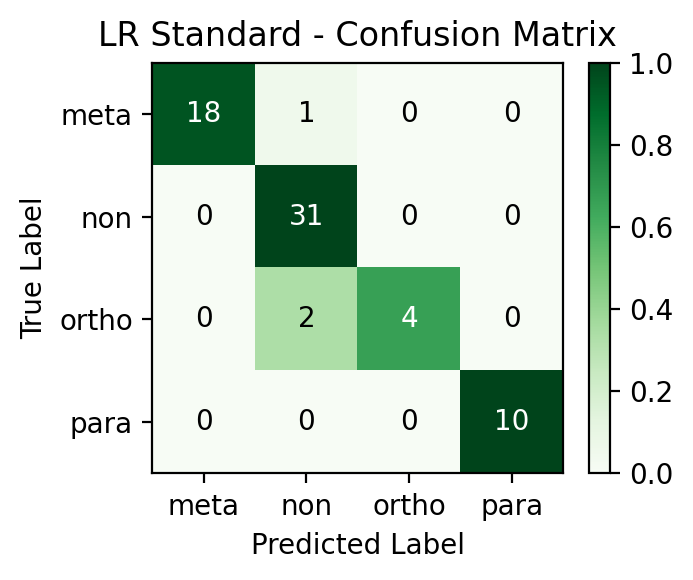

In [ ]:
cm_labels = list(le.classes_)
cm = confusion_matrix(true_labels, final_preds, labels=cm_labels)
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(4,3), dpi=200)

im = ax.imshow(cm_normalized, cmap='Greens')

ax.set_xticks(np.arange(len(cm_labels)))
ax.set_yticks(np.arange(len(cm_labels)))
ax.set_xticklabels(cm_labels)
ax.set_yticklabels(cm_labels)

for i in range(len(cm_labels)):
    for j in range(len(cm_labels)):
        value = cm[i, j]
        color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j, i, str(value), ha='center', va='center', color=color)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(labelsize=10)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("LR Standard - Confusion Matrix")
plt.tight_layout()
plt.show()

**Learning Curve**

Gap between training and validation scores at full dataset size: 0.1190

Final Model Performance:
Training F1: 0.988
Validation F1: 0.869


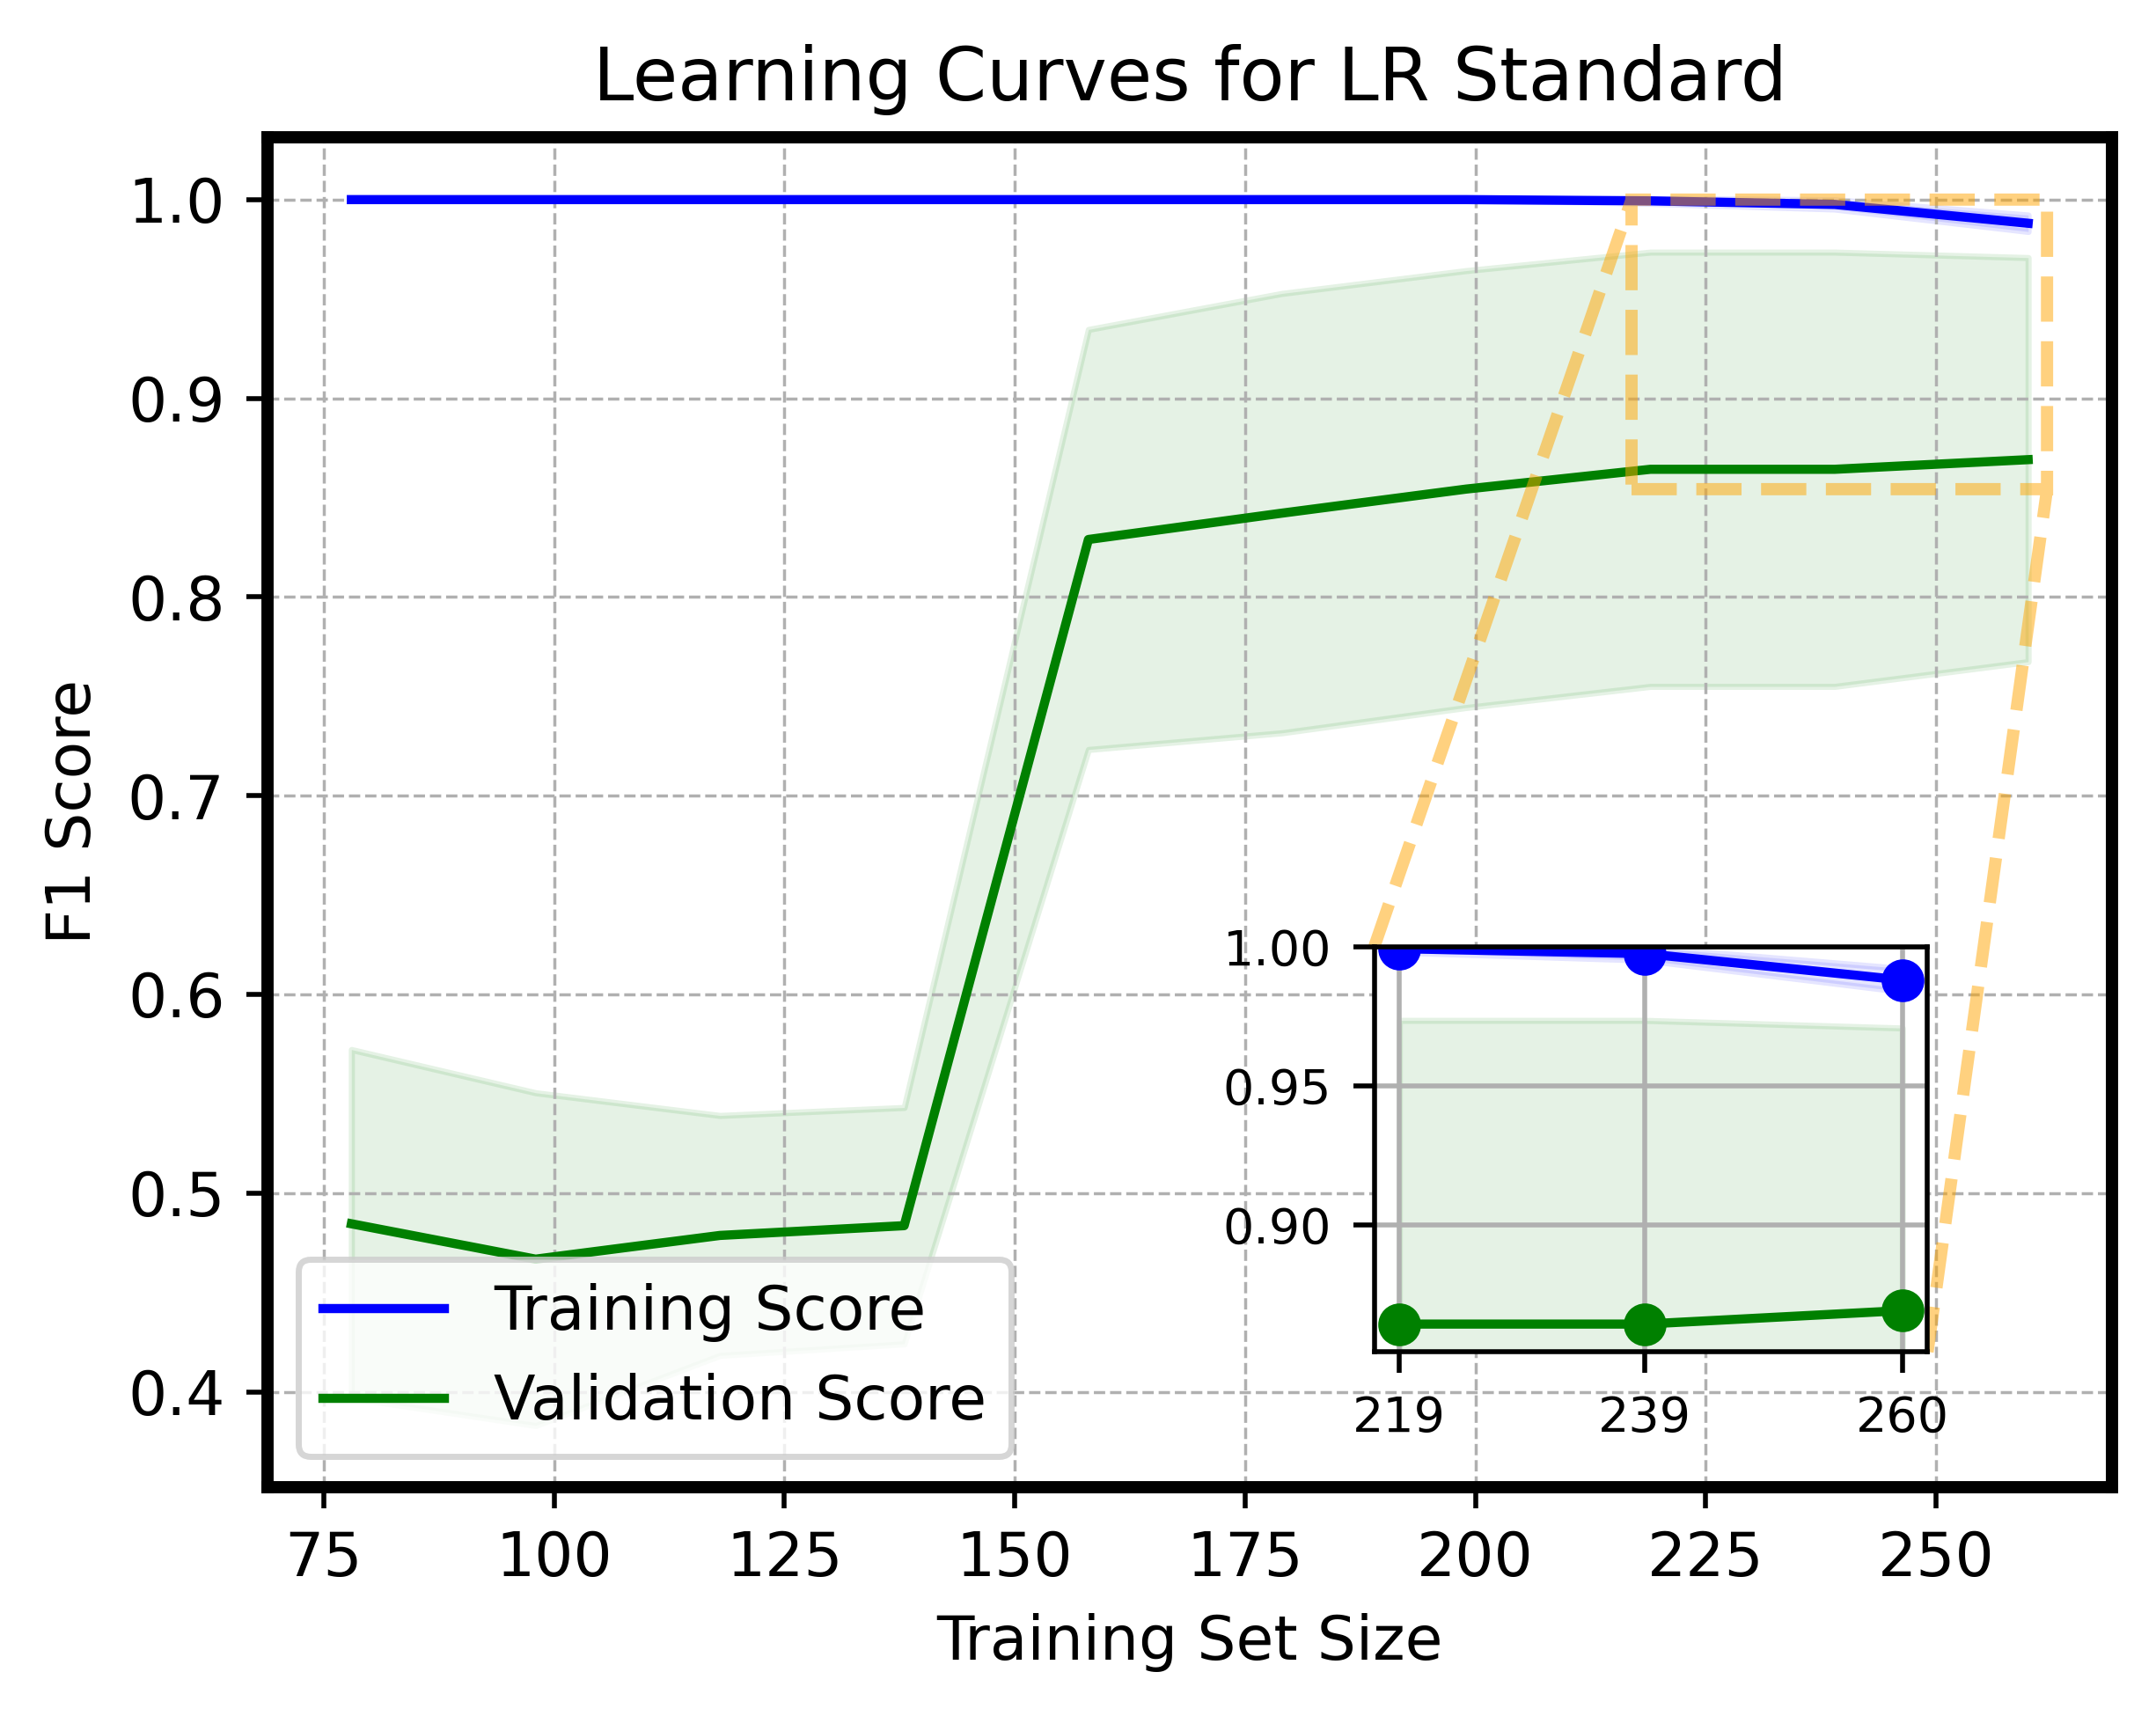

In [26]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y_encoded, cv=5, scoring='f1_macro', train_sizes=np.linspace(0.3, 1.0, 10), n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

gap_at_full_data = train_mean[-1] - test_mean[-1]
print(f"Gap between training and validation scores at full dataset size: {gap_at_full_data:.4f}")

print(f"\nFinal Model Performance:")
print(f"Training F1: {train_mean[-1]:.3f}")
print(f"Validation F1: {test_mean[-1]:.3f}")

plt.figure(figsize=(5, 4), dpi=500)
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, label="Validation Score", color="green")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

ax = plt.gca()
zoomed_inset = ax.inset_axes([0.6, 0.1, 0.3, 0.3])
zoomed_inset.plot(train_sizes[-3:], train_mean[-3:], 'o-', color="blue")
zoomed_inset.plot(train_sizes[-3:], test_mean[-3:], 'o-', color="green")
zoomed_inset.fill_between(train_sizes[-3:], train_mean[-3:] - train_std[-3:], train_mean[-3:] + train_std[-3:], alpha=0.1, color="blue")
zoomed_inset.fill_between(train_sizes[-3:], test_mean[-3:] - test_std[-3:], test_mean[-3:] + test_std[-3:], alpha=0.1, color="green")
zoomed_inset.set_xticks(train_sizes[-3:])
zoomed_inset.set_ylim([min(train_mean[-3:].min(), test_mean[-3:].min()) - 0.01, 1])
zoomed_inset.tick_params(axis='both', labelsize=8)
zoomed_inset.grid(True)

ax.indicate_inset_zoom(zoomed_inset, linestyle="--", edgecolor="orange", linewidth=2)

plt.title("Learning Curves for LR Standard")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.xticks()
plt.yticks()
plt.legend(loc="lower left")

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(2)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**Fragment Analysis**

In [ ]:
def enumerate_and_sort(coef_array):
    '''
    This function takes a 2d array of values and returns another 2d array of dictionary
    the final array has
    '''

    # Coeffecient array contains coeffecients assigned to each feature along columns for each class along rows
    # Shape : (number of classes, number of features)

    enumerated_list = []

    for class_coefs in coef_array:

        # class_coefs contains list of coeffecients assigned to corresponding features for a particular class.

        index_value_list = []
        index = 0

        for feature_coef in class_coefs:
            index_value = {'index': index, 'value': feature_coef}
            index_value_list.append(index_value)
            index += 1
        enumerated_list.append(index_value_list)

    for enumerated in enumerated_list:
        enumerated.sort(key=lambda index_value: abs(index_value['value']), reverse=True)

    return enumerated_list

In [ ]:
def get_important_morgan_fragments(model, fingerprints:list, fragments_per_class):

    '''
    This function takes a scikit-learn machine learning model, a list, and
    an integer as arguments.

    model : scikit-learn model with coefs_ attribute
    fingerprints: a list of Fingeprint objects
    fragments_per_class: maximum number of important fragments whose information is to be extracted

    Returns an array of shape (number of classes, fragments_per_class)
    '''

    # `model.coef_` returns an array of shape (number of classes, number of features)
    # The cells of the array contains coeffecient of a feature for the corresponding class.
    coef_array = model.coef_

    # getting a list of dictionaries containing feature index and coeffecient value arranged according
    sorted_coefs = enumerate_and_sort(coef_array)
    bit_infos = []
    all_on_bits = []
    for fingerprint in fingerprints:
        bit_infos.append(fingerprint.bit_info)
        all_on_bits.append(fingerprint.on_bits)

    imp_coefs = []
    for coef_list in sorted_coefs:
        imp_coefs.append(coef_list[:fragments_per_class])

    fragments_array = []
    legends_array = []

    for bit_list in imp_coefs:
        fragments = []
        legends = []
        for index_value in bit_list:
            index = index_value.get('index')
            index_found = False
            for fingerprint in fingerprints:
                if index in fingerprint.on_bits:
                    index_found = True
                    mol = fingerprint.mol
                    bit_info = fingerprint.bit_info
                    legends.append(f"bit: {index_value.get('index')} | value: {round(index_value.get('value'), 4)}")
                    fragments.append((mol, index, bit_info))
                    break
            if not index_found:
                print("Warning Bit not found")

        fragments_array.append(fragments)
        legends_array.append(legends)
    return fragments_array, legends_array

In [ ]:
fragments_array, legends_array = get_important_morgan_fragments(best_model, Fingerprint.fingerprints, 16)

3


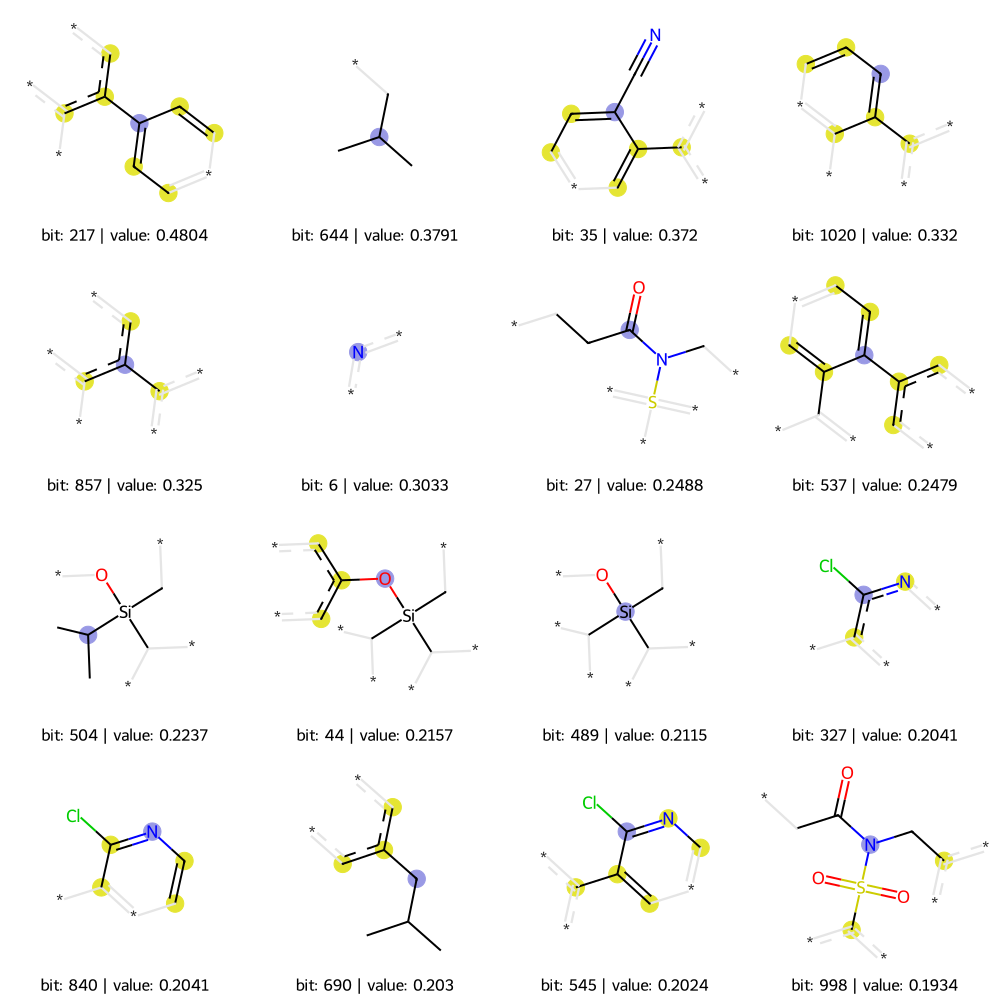

In [ ]:
n=3 # 0:META, 2:ORTHO, 3:PARA
print(best_model.classes_[n])
Draw.DrawMorganBits(fragments_array[n][:100],
                    legends=legends_array[n][:100],
                    molsPerRow=4,
                    useSVG=True,
                    subImgSize=(250, 250)
                   )